# Taller Aprendizaje Supervisado 👨🏽‍🏫

```
Integrantes = [
    'Daniel Andrade',
    'Gabriel Cubides',
    'Dewith Miramón',
    'Santiago Prado'
]

```

In [ ]:
# Data
import re
import numpy as np
import pandas as pd

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
import grap_func

# Machine Learning
from sklearn.datasets import load_wine
from sklearn import preprocessing, model_selection, impute
from sklearn import linear_model, svm, neighbors, tree, ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

## Punto 1

A pesar de que Airbnb no permite acceder a sus datos directamente un grupo independiente llamado inside
airbnb ha recolectado datos acerca de los alquileres ofrecidos por esta organización en la mayoría de las
grandes ciudades del mundo. En este caso, analizaremos datos obtenido el 3 de octubre del 2015 con la
información de los alquileres disponibles en la ciudad de Washington D.C. El conjunto de datos cuenta
con 3724 registros y las siguientes características:


- ```accommodates```: número de personas que el lugar puede albergar
- ```bedrooms```: número de habitaciones disponibles
- ```bathrooms```: número de baños disponibles
- ```beds```: número de camas disponibles
- ```price```: precio por noche
- ```cleaning_fee```: cargo adicional por limpieza luego que el visitante se retira
- ```security_deposit```: deposito reembolsable en caso de daños
- ```minimum_nights```: número mínimo de noches
- ```maximum_nights```: número máximo de noches
- ```number_of_reviews```: número de comentarios (reviews) disponibles

Su objetivo es construir un modelo de regresión que permita estimar el precio de alquiler para una nueva
ubicación.

### A. Análisis exploratorio



In [ ]:
airbnb = pd.read_csv('https://raw.githubusercontent.com/jpospinalo/MachineLearning/main/knn/airbnb.csv')
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       3723 non-null   int64  
 1   bedrooms           3702 non-null   float64
 2   bathrooms          3696 non-null   float64
 3   beds               3712 non-null   float64
 4   price              3723 non-null   object 
 5   cleaning_fee       2335 non-null   object 
 6   security_deposit   1426 non-null   object 
 7   minimum_nights     3723 non-null   int64  
 8   maximum_nights     3723 non-null   int64  
 9   number_of_reviews  3723 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 291.0+ KB


In [ ]:
airbnb.columns

Index(['accommodates', 'bedrooms', 'bathrooms', 'beds', 'price',
       'cleaning_fee', 'security_deposit', 'minimum_nights', 'maximum_nights',
       'number_of_reviews'],
      dtype='object')

In [ ]:
features_airbnb =   ['accommodates', 'bedrooms', 'bathrooms', 'beds',
                     'cleaning_fee', 'security_deposit', 'minimum_nights', 
                     'maximum_nights', 'number_of_reviews']
target_airbnb = "price"

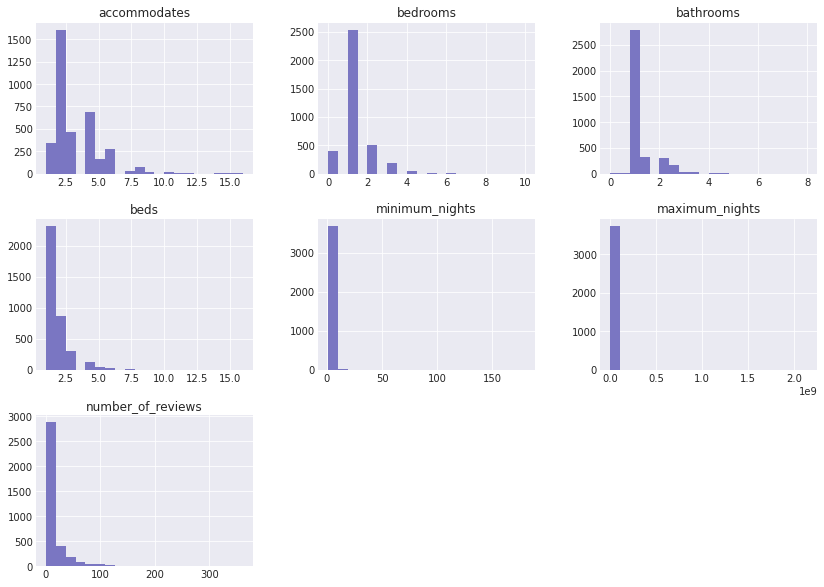

In [ ]:
airbnb.hist(layout=(3, 3), figsize=(14, 10), bins=20)
plt.show()

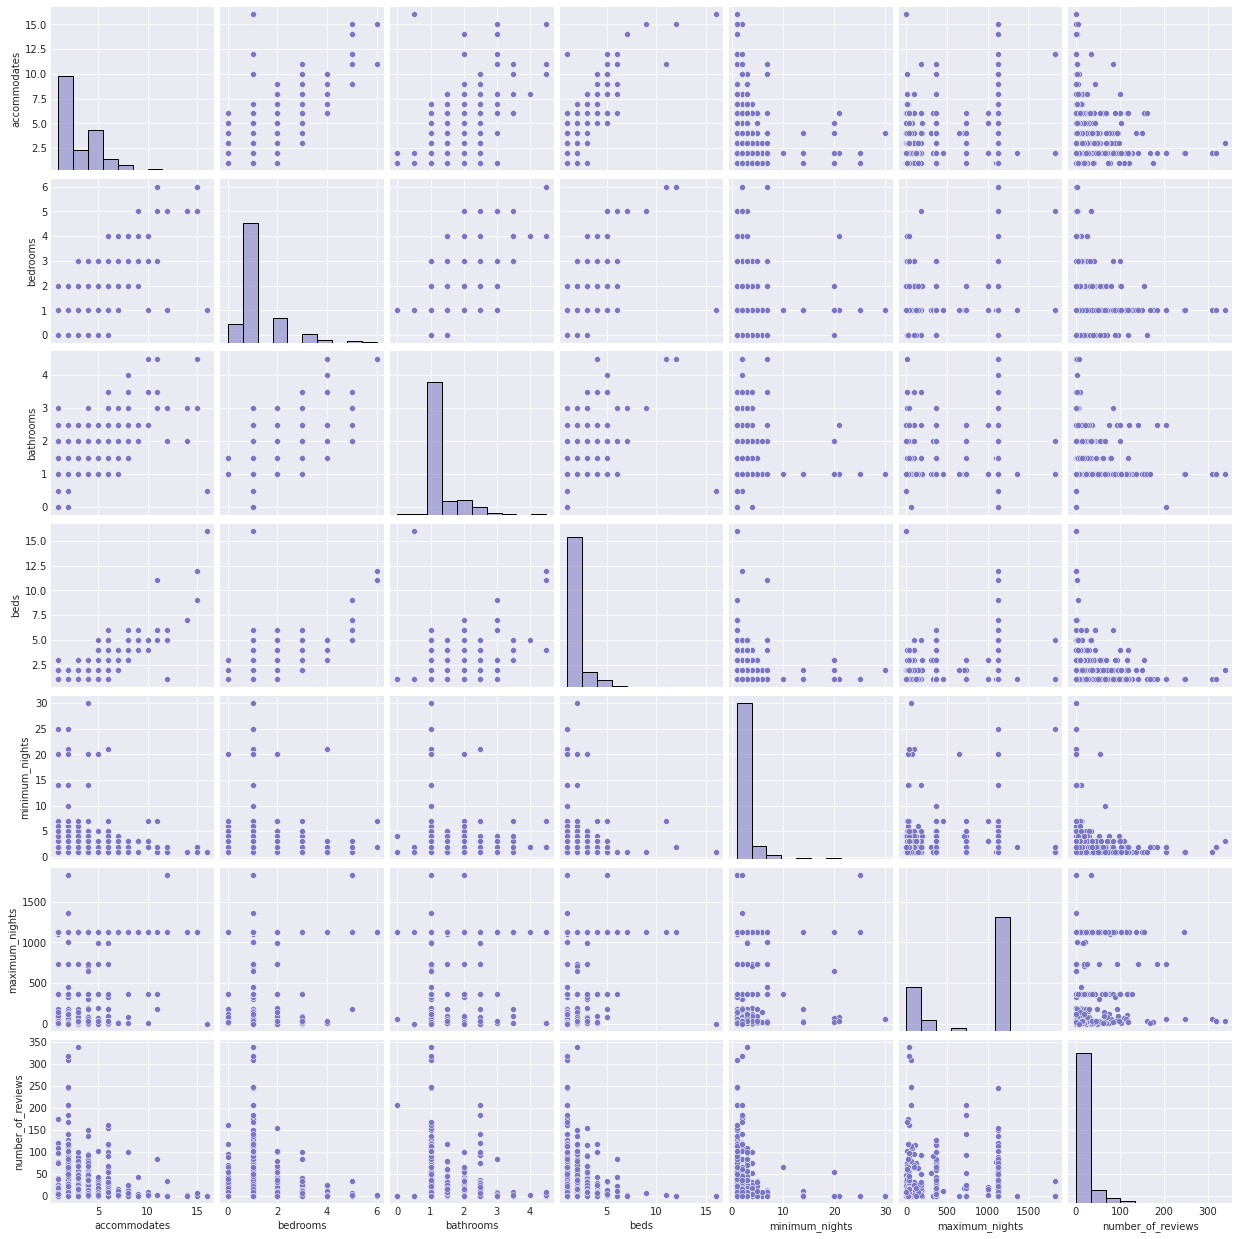

CPU times: user 7.55 s, sys: 381 ms, total: 7.93 s
Wall time: 7.87 s


In [ ]:
%%time
sns.pairplot(airbnb.sample(1000), 
            vars = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 
                    'minimum_nights', 'maximum_nights',
                    'number_of_reviews'], #hue = "Class", 
             diag_kind = "hist", 
             diag_kws = {'alpha':0.55, 'bins': 10})
plt.show()

### B. Preparación de los datos

#### Limpieza de valores

In [ ]:
def clean_money(value):
    if pd.isna(value):
        money = value
    else:
        money = re.sub(r'[^0-9.]', '', value)
        money = float(money)
    return money

In [ ]:
airbnb_clean = airbnb.copy()
airbnb_clean['price'] = airbnb_clean['price'].apply(clean_money)
airbnb_clean['cleaning_fee'] = airbnb_clean['cleaning_fee'].apply(clean_money)
airbnb_clean['security_deposit'] = airbnb_clean['security_deposit'].apply(clean_money)

In [ ]:
airbnb_clean.sample(3)

,accommodates,bedrooms,bathrooms,beds,price,cleaning_fee,security_deposit,minimum_nights,maximum_nights,number_of_reviews
3327,1,1.0,1.0,1.0,50.0,35.0,100.0,2,1125,5
480,3,1.0,1.0,2.0,130.0,30.0,NaN,3,1125,44
61,1,1.0,1.0,1.0,65.0,NaN,NaN,1,1125,2


#### Tratado de nulos

In [ ]:
airbnb_clean.isna().sum() / len(airbnb_clean) * 100

accommodates          0.000000
bedrooms              0.564061
bathrooms             0.725222
beds                  0.295461
price                 0.000000
cleaning_fee         37.281762
security_deposit     61.697556
minimum_nights        0.000000
maximum_nights        0.000000
number_of_reviews     0.000000
dtype: float64

In [ ]:
# Replacing NaN with 0 (Cleaning fee, Security deposit)
null_cols = ['cleaning_fee', 'security_deposit']
airbnb_clean[null_cols] = airbnb_clean[null_cols].fillna(0)


In [ ]:
# Drop Columns with NaN 
drop_rows_nan = ['bedrooms', 'bathrooms', 'beds']
airbnb_clean  = airbnb_clean.dropna(subset=drop_rows_nan)

In [ ]:
#Verification post Drop/Replace NaN
airbnb_clean.isna().sum() / len(airbnb_clean) * 100

accommodates         0.0
bedrooms             0.0
bathrooms            0.0
beds                 0.0
price                0.0
cleaning_fee         0.0
security_deposit     0.0
minimum_nights       0.0
maximum_nights       0.0
number_of_reviews    0.0
dtype: float64

#### separación train/test

In [ ]:
X_ab, y_ab = airbnb_clean[features_airbnb].to_numpy(), airbnb_clean[target_airbnb].to_numpy().reshape(-1,1)
X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(X_ab, y_ab, random_state=1)

#### Limpieza outliers

In [ ]:
df_train_ab = pd.DataFrame(X_train_ab, columns=features_airbnb)
df_train_ab['price'] = y_train_ab

In [ ]:
# Removing the outliers
def removeOutliers(data, col, target):
    if col==target:
        pass
    else:
        Q3 = np.quantile(data[col], 0.75)
        Q1 = np.quantile(data[col], 0.25)
        IQR = Q3 - Q1
        
        print("IQR value for column %s is: %s" % (col, IQR))
        global outlier_free_list
        global filtered_data
        
        lower_range = Q1 - 1.5 * IQR
        upper_range = Q3 + 1.5 * IQR
        outlier_free_list = [x for x in data[col] if (((x > lower_range) & (x < upper_range))|pd.isna(x))]
        filtered_data = data.loc[data[col].isin(outlier_free_list)]
    
 
for i in df_train_ab.columns:
    removeOutliers(df_train_ab, i, target_airbnb)


# Assigning filtered data back to our original variable
df_train_out_rem_ab = filtered_data

print("Shape of data after outlier removal is: ", df_train_out_rem_ab.shape)

IQR value for column accommodates is: 2.0
IQR value for column bedrooms is: 0.0
IQR value for column bathrooms is: 0.0
IQR value for column beds is: 1.0
IQR value for column cleaning_fee is: 55.0
IQR value for column security_deposit is: 150.0
IQR value for column minimum_nights is: 2.0
IQR value for column maximum_nights is: 1027.0
IQR value for column number_of_reviews is: 16.0
Shape of data after outlier removal is:  (2455, 10)


In [ ]:
X_train_ab = df_train_out_rem_ab.loc[:, features_airbnb].copy()
y_train_ab = df_train_out_rem_ab[target_airbnb].values

### C. Modelado

Generar diferentes modelos utilizando regresión lineal, regresión polinomial, regresión de Lasso,
regresión de Ridge, árboles de decisión, bosques aleatorios y el algoritmo de los k vecinos más próximos.

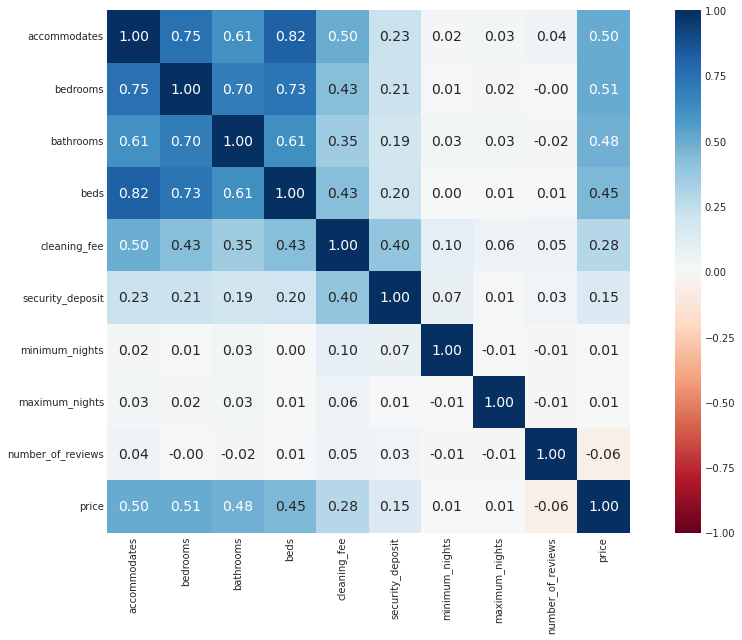

In [ ]:
plt.figure(figsize=(13, 9))
corr = df_train_out_rem_ab.corr()
sns.heatmap(
    data = corr, cbar=True, square=True, annot=True, 
    fmt= '.2f', annot_kws={'size': 14}, 
    xticklabels= corr.columns, yticklabels= corr.columns,
    vmin=-1, vmax=1,
    cmap="RdBu"
)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [ ]:
models = [
    ('Regresión Lineal', linear_model.LinearRegression()),
    ('Regresión Polinomial Grado 2', pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=2, interaction_only=True), 
        linear_model.LinearRegression())
    ),
    ('Regresión Polinomial Grado 3', pipeline.make_pipeline(
        preprocessing.PolynomialFeatures(degree=3, interaction_only=True), 
        linear_model.LinearRegression())
    ),
    ('Regresión Lasso', linear_model.Lasso(alpha=1.0)),
    ('Regresión Ridge',  linear_model.Ridge(alpha=1.0)),
    ('Arbol de Decisión', tree.DecisionTreeRegressor()),
    ('Bosques Aleatorios', ensemble.RandomForestRegressor(random_state=42)),
    ('Vecinos más Cercanos', neighbors.KNeighborsRegressor(n_neighbors=10))
]

In [ ]:
%%time
scoring = {
    'r2': metrics.make_scorer(metrics.r2_score),
    'mae': metrics.make_scorer(metrics.mean_absolute_error),
    'rsme': metrics.make_scorer(metrics.mean_squared_error, 
                                greater_is_better=True, 
                                squared=False)
}

scores = dict()
for name, model in models:
    print(f'Entrenando {name}')
    pipe = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        model,
    )
    score = model_selection.cross_validate(pipe, X_train_ab, y_train_ab, 
                                            cv=5, return_train_score=True,
                                            scoring=scoring)
    scores[name] = score

Entrenando Regresión Lineal
Entrenando Regresión Polinomial Grado 2
Entrenando Regresión Polinomial Grado 3
Entrenando Regresión Lasso
Entrenando Regresión Ridge
Entrenando Arbol de Decisión
Entrenando Bosques Aleatorios
Entrenando Vecinos más Cercanos
CPU times: user 4.55 s, sys: 988 ms, total: 5.54 s
Wall time: 6.55 s


In [ ]:
cols = ['Model', 'Set', 'R2_mean', 'R2_std', 'MAE_mean', 'MAE_std', 'RSME_mean', 'RSME_std']
results = pd.DataFrame(columns=cols)
for model, score in scores.items():

    result = pd.DataFrame(
        data=[
            (
                model, 'Train', 
                round(score['train_r2'].mean(), 2), score['train_r2'].std(),
                round(score['train_mae'].mean(), 1), score['train_mae'].std(),
                round(score['train_rsme'].mean(), 1), score['train_rsme'].std()
            ),
            (
                model, 'Test', 
                round(score['test_r2'].mean(), 2), score['test_r2'].std(),
                round(score['test_mae'].mean(), 1), score['test_mae'].std(),
                round(score['test_rsme'].mean(), 1), score['test_rsme'].std()
            )
        ],
        columns=cols
    )
    results = pd.concat([results, result], axis=0)

### D. Evaluación
Realice la evaluación del modelo utilizando validación cruzada

In [ ]:
results

,Model,Set,R2_mean,R2_std,MAE_mean,MAE_std,RSME_mean,RSME_std
0,Regresión Lineal,Train,0.32,0.018822,57.0,1.017524,117.9,5.106753
1,Regresión Lineal,Test,0.30,0.115821,57.8,2.076853,119.3,21.356452
0,Regresión Polinomial Grado 2,Train,0.42,0.017969,55.0,0.907371,108.9,3.506363
1,Regresión Polinomial Grado 2,Test,-1081.43,2163.346064,148.4,178.162976,2081.2,3912.053972
0,Regresión Polinomial Grado 3,Train,0.54,0.020792,52.4,0.645304,97.2,2.682287
1,Regresión Polinomial Grado 3,Test,-65.98,83.464141,94.2,34.245405,744.5,707.770814
0,Regresión Lasso,Train,0.32,0.018938,56.8,0.965171,117.9,5.118837
1,Regresión Lasso,Test,0.32,0.101268,57.1,2.058398,117.5,21.449853
0,Regresión Ridge,Train,0.32,0.018822,57.0,1.016495,117.9,5.106755
1,Regresión Ridge,Test,0.30,0.115917,57.8,2.078058,119.3,21.360013


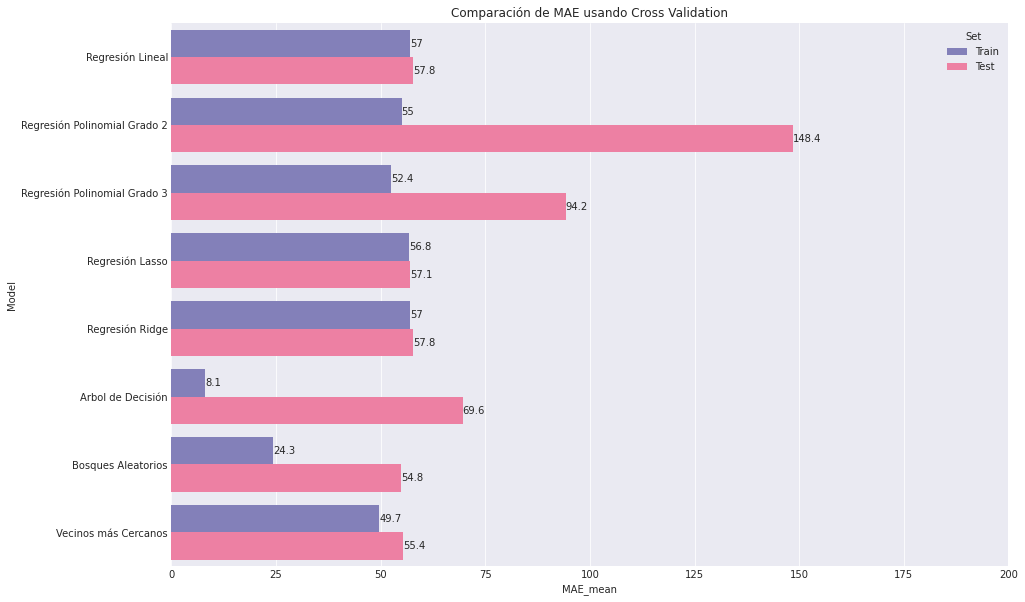

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(data=results, y='Model', x='MAE_mean', hue='Set')
for container in ax.containers:
    ax.bar_label(container)
plt.xlim(0, 200)
#plt.xticks(rotation=45, ha='right')
plt.title('Comparación de MAE usando Cross Validation')
plt.show()

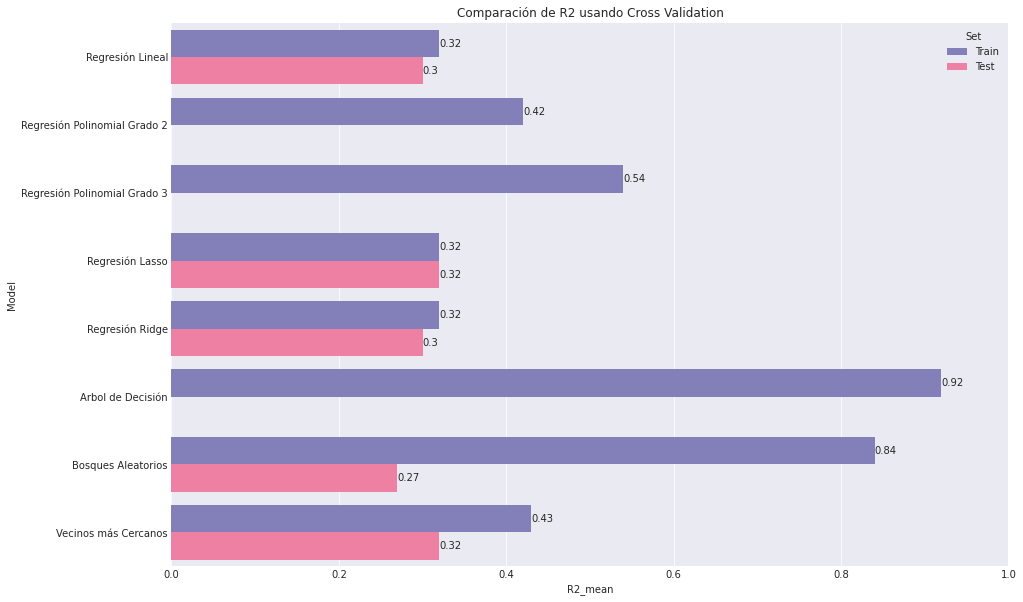

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(data=results, y='Model', x='R2_mean', hue='Set')
for container in ax.containers:
    ax.bar_label(container)
plt.xlim(0, 1)
#plt.xticks(rotation=45, ha='right')
plt.title('Comparación de R2 usando Cross Validation')
plt.show()


### E. Selección
A partir de los resultados obtenidos seleccione el modelo que a su modo de ver ofrece la mejor solución.
Justifique su respuesta.

> El mejor modelo usando las métricas R2 y MAE fue Vecinos más cercanos. Además al comparar los resultados de trian podemos notar que el modelo no se sobreajusta a los datos.
> Cuando entrenamos este modelo con todos los datos de entrenamiento y al evaluarlo con el set de evalución el error fue de 54 USD, teniendo en cuenta que el promedio de los precios era de 153 USD.


In [ ]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):
    '''Creates multiple plots to evaluate the model performance visually.'''
    from matplotlib.ticker import FuncFormatter
    from matplotlib.gridspec import GridSpec
    
    # This is optional, it's made for large values (i.e., money)
    def kilos(x, pos):
        'The two args are the value and tick position'
        return '{:.0f}'.format(x)
    formatter = FuncFormatter(kilos)
    # End of optional
    
    fig = plt.figure(constrained_layout=False, figsize=(12, 9))
    widths = [5, 5]
    heights = [3, 5]
    gs = fig.add_gridspec(ncols=2, nrows=2, wspace=0.4, hspace=0.35,
                          width_ratios=widths,
                          height_ratios=heights)
    
    # Histogram of Errors
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title('Histogram of Errors')
    train_errors = y_train - y_train_pred
    test_errors = y_test - y_test_pred
    rango = (min(np.min(train_errors), 
                 np.min(test_errors)),
             max(np.max(train_errors), 
                 np.max(test_errors))) 
    
    errors_data = list(zip(
        np.concatenate([train_errors, test_errors]), 
        np.concatenate([np.full(len(train_errors), 'Train'), np.full(len(test_errors), 'Test')])
    ))
    errors = pd.DataFrame(errors_data, columns=['error', 'set'])
    sns.histplot(data=errors, x='error', hue='set', kde=False, bins=45, stat='probability', common_norm=False,
                 hue_order=['Train', 'Test'], element='step', ax=ax1, legend=True)
    ax1.set_ylabel('Density')
    ax1.set_xlabel('Error')
    ax1.xaxis.set_major_formatter(formatter)
    
    # Residuals plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title('Residuals Plot')
    ax2.scatter(y_train_pred,  y_train_pred - y_train,
               s=25, edgecolor='white', linewidths=0.5, alpha=1,
               label='Train')
    ax2.scatter(y_test_pred, y_test_pred - y_test, 
               s=25, edgecolor='white', linewidths=0.5, alpha=1,
               label='Test')
    ax2.hlines(y=0, 
               xmin=np.min(ax2.get_xlim()), 
               xmax=np.max(ax2.get_xlim()), 
               color='black', alpha=1,
               lw=2)
    ax2.set_xlabel('Predicted values')
    ax2.set_ylabel('Residuals')
    ax2.legend(fancybox=True, loc='lower right')
    ax2.xaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    
    
    # Prediction errors  plot
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_title('Prediction Errors Plot')
    ax3.scatter(y_test, y_test_pred, #color=red,
                s=25, edgecolor='white', linewidths=0.5, alpha=1)
    lims = [np.min([ax3.get_xlim(), ax3.get_ylim()]),
            np.max([ax3.get_xlim(), ax3.get_ylim()])] 
    ax3.plot(lims, lims, '-k',  alpha=1, lw=2, label='Identity', color='black')
    sns.regplot(x=y_test, y=y_test_pred, scatter=False, ci=None,
                color='black', label='Best fit',
                line_kws={'ls': '--', 'alpha':0.6, 'lw':2})
    ax3.set_xlabel('Real (test)')
    ax3.set_ylabel('Predicted (test)')
    ax3.legend(fancybox=True, loc='lower right')
    ax3.xaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_formatter(formatter)
    plt.show()

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
pipe = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    knn,
)
pipe.fit(X_train_ab, y_train_ab)

y_train_ab_pred = pipe.predict(X_train_ab)
y_test_ab_pred = pipe.predict(X_test_ab)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
knn_metrics = {
    'Media': round(np.mean(y_test_ab), 2),
    'MAE': round(metrics.mean_absolute_error(y_test_ab, y_test_ab_pred), 2),
    'RMSE': round(np.sqrt(metrics.mean_squared_error(y_test_ab, y_test_ab_pred)), 2), 
    'R2': round(metrics.r2_score(y_test_ab, y_test_ab_pred), 3)
}
for metric, value in knn_metrics.items():
    print(f"{metric}: {value}")

Media: 153.18
MAE: 54.3
RMSE: 104.82
R2: 0.407


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.


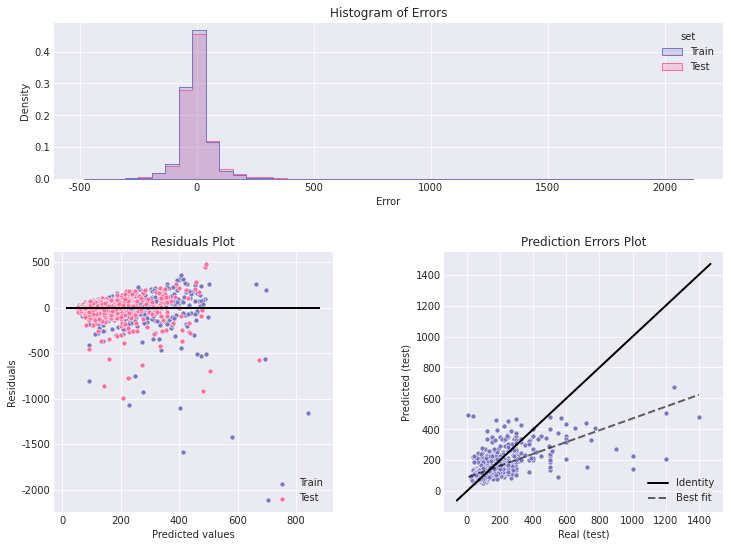

In [ ]:
evaluate_model(
    y_train_ab, 
    y_train_ab_pred, 
    y_test_ab.reshape(-1), 
    y_test_ab_pred
)

## Punto 2

Para este ejercicio se utilizarán los resultados de un análisis químico realizado a distintos vinos producidos
en una misma región de Italia, pero provenientes de distintos cultivos. El análisis encontró la presencia
de 13 componentes en 3 diferentes clases de vino. Su objetivo es construir un modelo de clasificación que
permita predecir el tipo de vino a partir de sus componentes.

### A. Análisis exploratorio



In [ ]:
wine_ds = load_wine(as_frame=True)
wine_ds = wine_ds['frame']

print(wine_ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

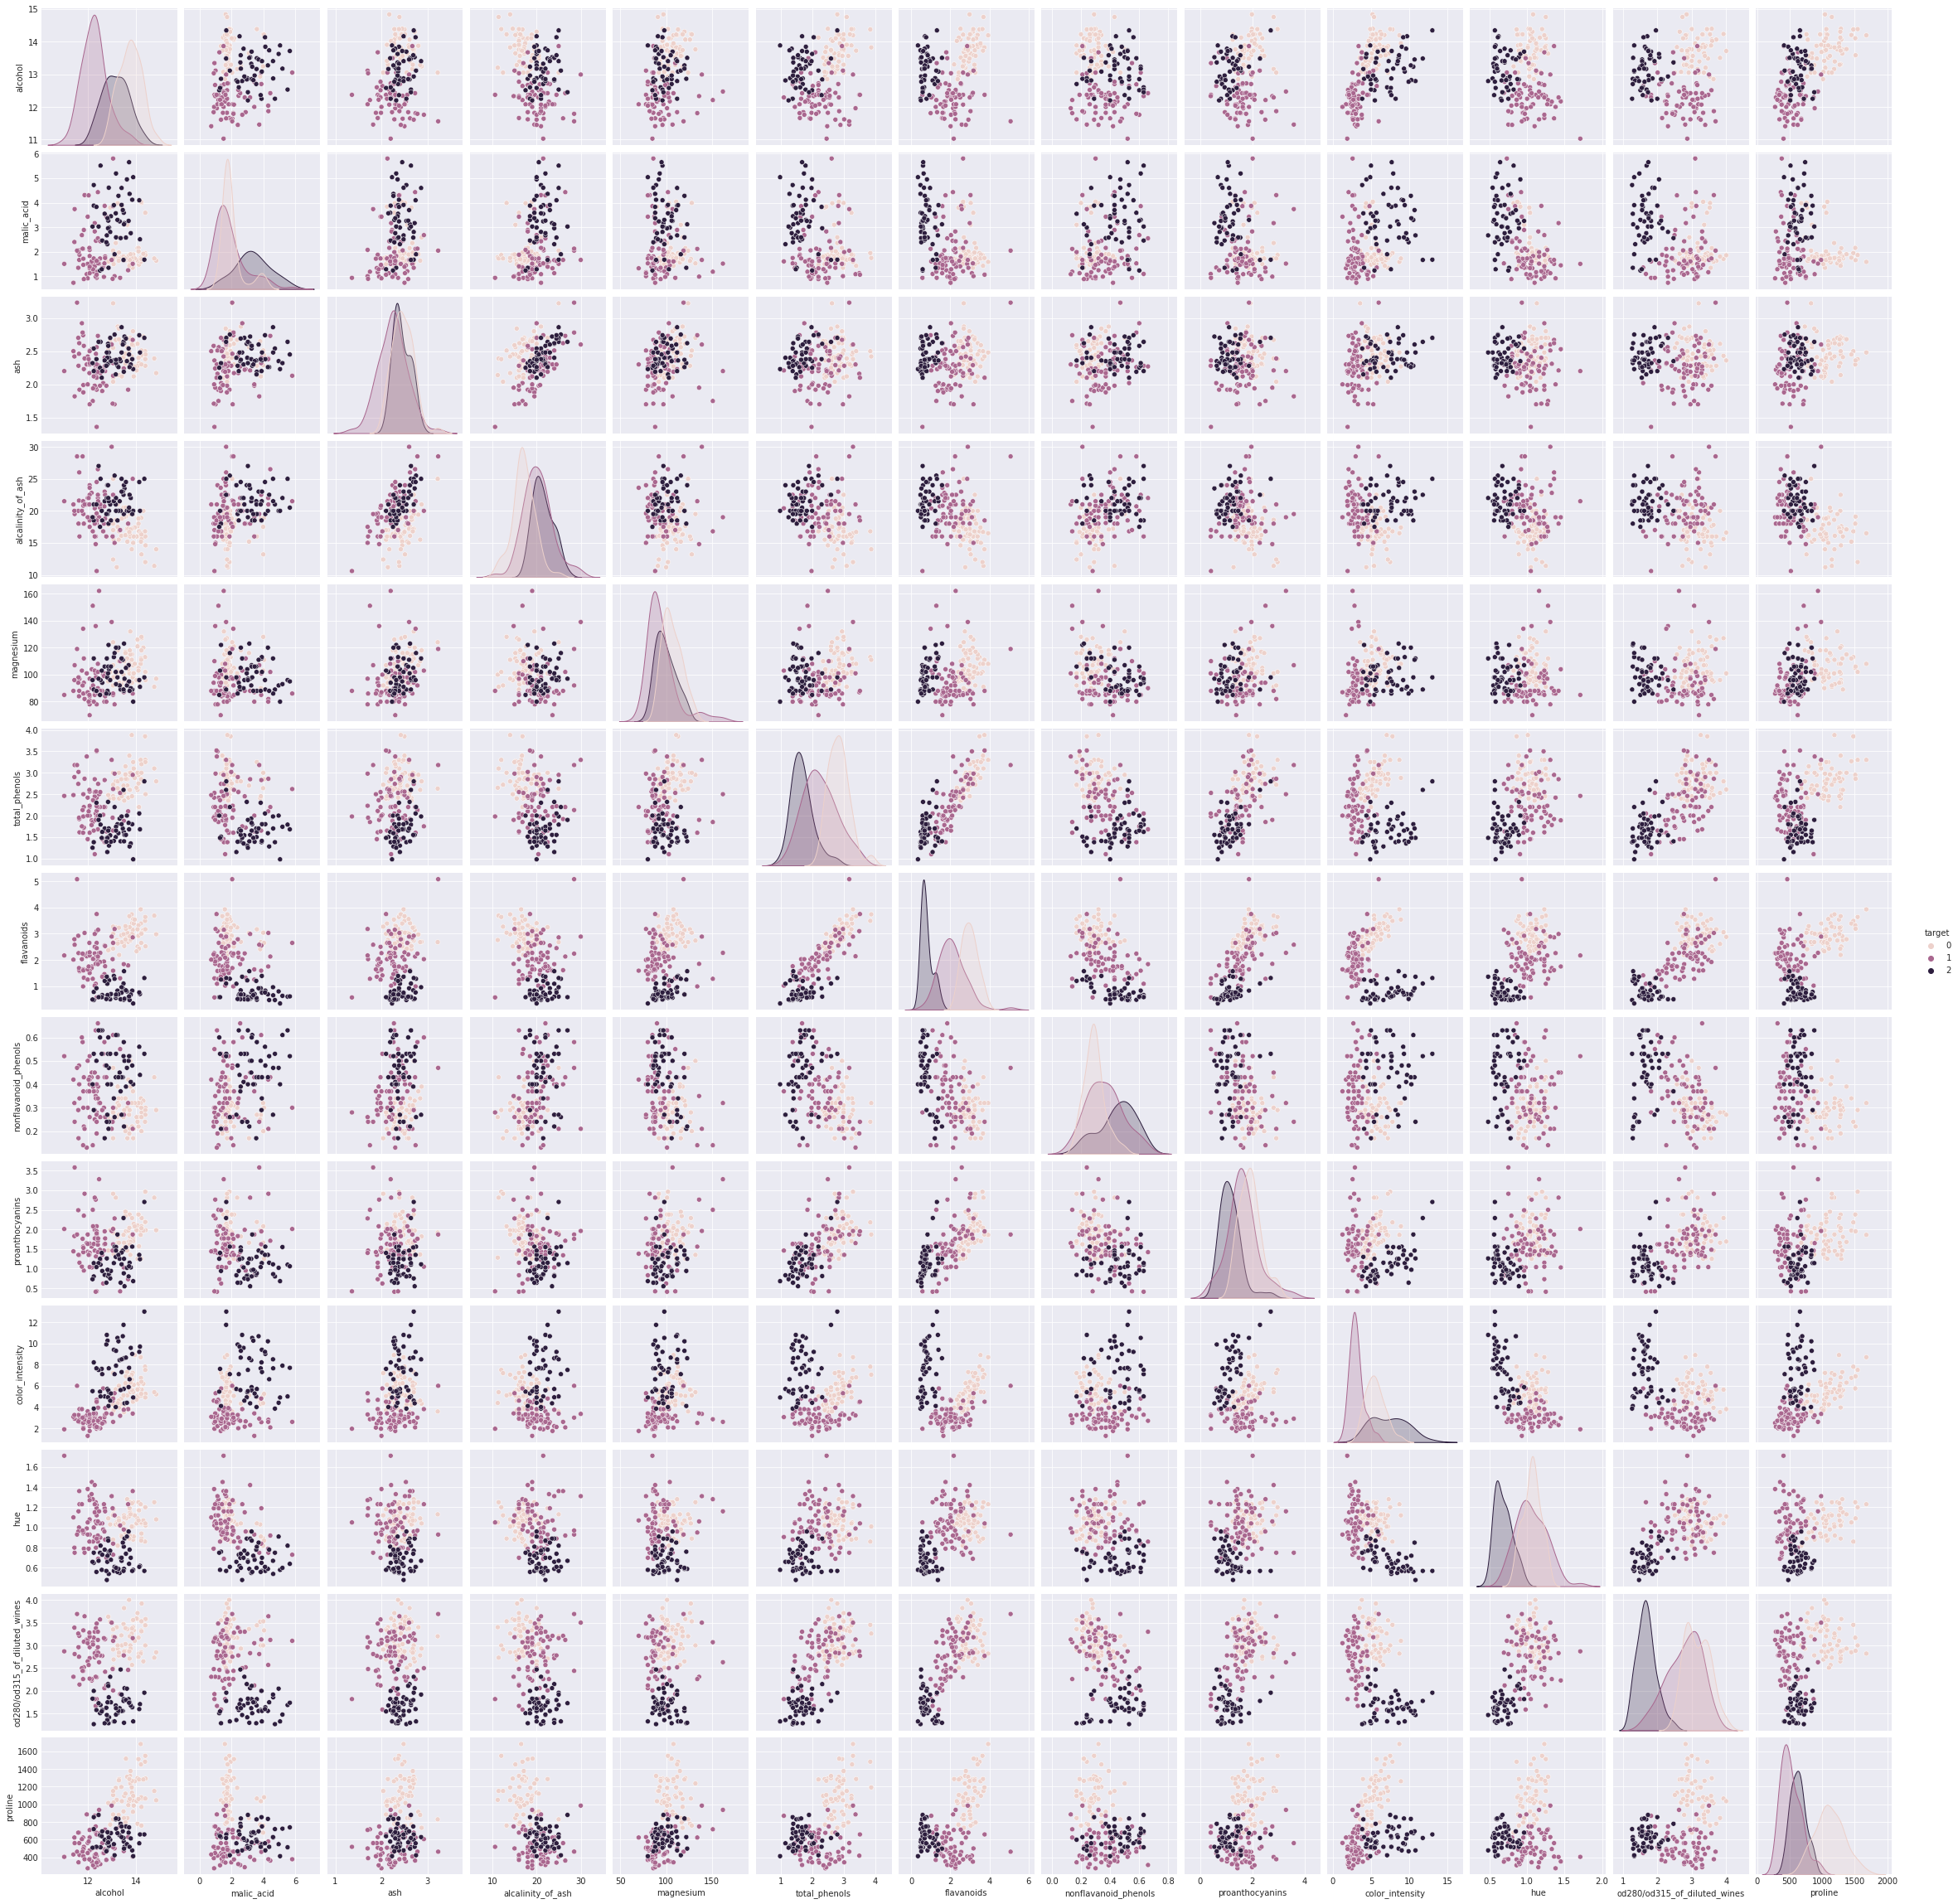

In [ ]:
sns.pairplot(data=wine_ds, hue='target')

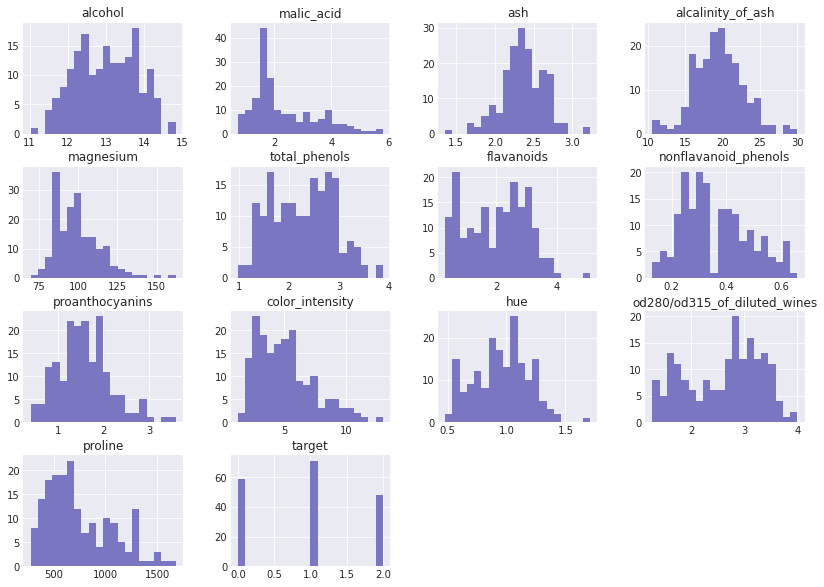

In [ ]:
wine_ds.hist(layout=(4, 4), figsize=(14, 10), bins=20)
plt.show()

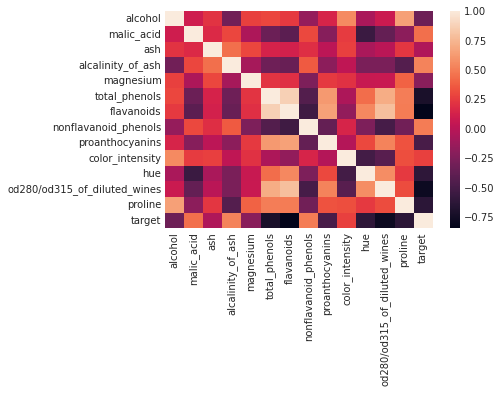

In [ ]:
sns.heatmap(wine_ds.corr())
plt.show()

In [ ]:
wine_ds.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

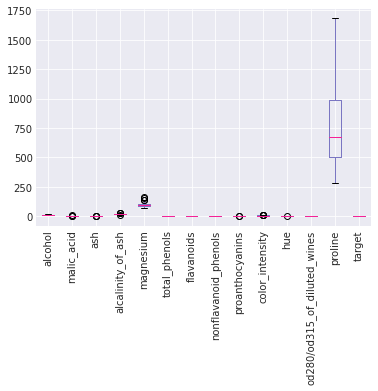

In [ ]:
wine_ds.boxplot()
plt.xticks(rotation=90)
plt.show()

### B. Preparación de los datos

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
X = wine_ds.drop(columns='target')
X = scaler.fit_transform(X)
y = wine_ds['target'].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True )

In [ ]:
y.shape

(178,)

### C. Modelado

Generar diferentes modelos utilizando perceptrón multicapa, regresión logística, Naive Bayes, árboles
de decisión, bosques aleatorios, el algoritmo de los k-vecinos más próximos y vectores de soporte.

##### 1. Perceptrón multicapa


In [ ]:
model_p = MLPClassifier(random_state=1, max_iter=300)
clf_p = model_p.fit(X_train, y_train)
y_pred_p = clf_p.predict(X_test)

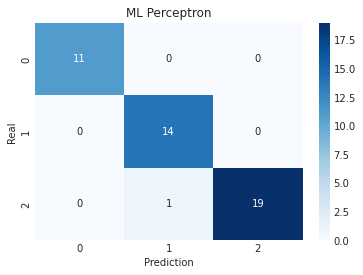

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_p), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('ML Perceptron')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.97        14
           2       1.00      0.95      0.97        20

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



##### 2. Regresión logistica

In [ ]:
model_l = linear_model.LogisticRegression()
clf_l = model_l.fit(X_train, y_train)
y_pred_l = clf_l.predict(X_test)

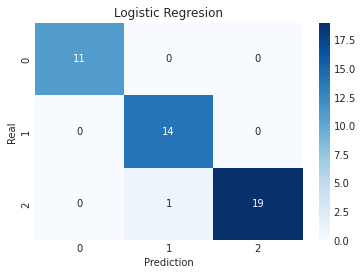

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_l), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Logistic Regresion')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_l))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.97        14
           2       1.00      0.95      0.97        20

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



##### 3. Naive Bayes

In [ ]:
model_n = GaussianNB()
clf_n = model_n.fit(X_train, y_train)
y_pred_n = clf_n.predict(X_test)

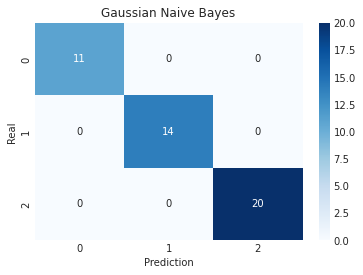

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_n), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Gaussian Naive Bayes')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_n))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        20

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



##### 4. Arboles de desición

In [ ]:
model_t = DecisionTreeClassifier()
clf_t = model_t.fit(X_train, y_train)
y_pred_t = clf_t.predict(X_test)

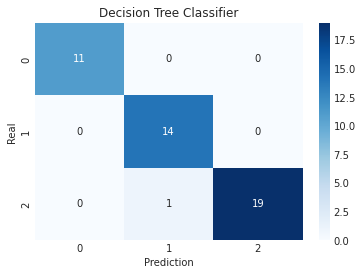

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_t), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Decision Tree Classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_t))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.97        14
           2       1.00      0.95      0.97        20

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



##### 4. Bosques Aleatorios

In [ ]:
model_f = RandomForestClassifier()
clf_f = model_f.fit(X_train, y_train)
y_pred_f = clf_f.predict(X_test)

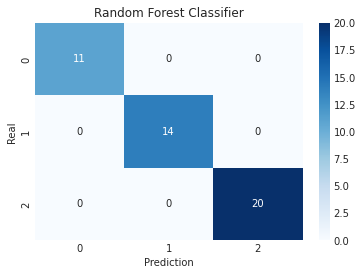

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_f), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Random Forest Classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_f))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        20

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



##### 5. KNN

In [ ]:
model_k = neighbors.KNeighborsClassifier(n_neighbors=30)
clf_k = model_k.fit(X_train, y_train)
y_pred_k = clf_k.predict(X_test)

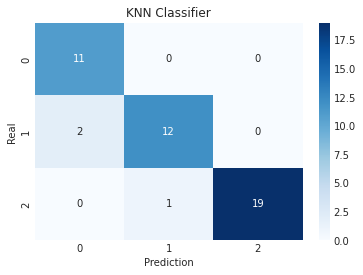

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_k), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('KNN Classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_k))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       0.92      0.86      0.89        14
           2       1.00      0.95      0.97        20

    accuracy                           0.93        45
   macro avg       0.92      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



##### 5. SVM

In [ ]:
model_s = SVC()
clf_s = model_s.fit(X_train, y_train)
y_pred_s = clf_s.predict(X_test)

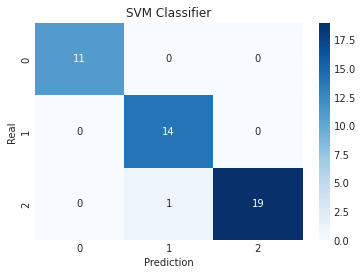

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_s), annot=True, cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('SVM Classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_s))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.93      1.00      0.97        14
           2       1.00      0.95      0.97        20

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



### D. Evaluación
Realice la evaluación del modelo utilizando validación cruzada

In [ ]:
classification_models = [model_p, model_l, model_n, model_t, model_f, model_k, model_s]

In [ ]:
scores_class = []
for model in classification_models:
    scores_class.append(model_selection.cross_val_score(model, X_test, y_test, cv = 5, scoring='accuracy').mean())

#train_scores = []
#for model in classification_models:
#    scores_class.append(model_selection.cross_val_score(model, X_train, y_train, cv = 8, scoring='accuracy').mean())

models_names = ['ML_Perceptron', 'Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest', 'KNN', 'SVM']
results_cls = pd.DataFrame({'Model': models_names, 'Score': scores_class}).sort_values(by='Score', ascending=False).round(5)

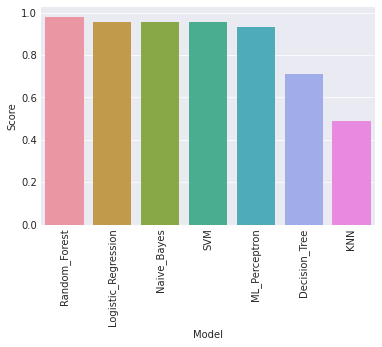

In [ ]:
sns.barplot(data = results_cls, x='Model', y='Score')
plt.xticks(rotation=90)
plt.show()

In [ ]:
results_cls

,Model,Score
4,Random_Forest,0.97778
1,Logistic_Regression,0.95556
2,Naive_Bayes,0.95556
6,SVM,0.95556
0,ML_Perceptron,0.93333
3,Decision_Tree,0.75556
5,KNN,0.48889


### E. Selección
A partir de los resultados obtenidos seleccione el modelo que a su modo de ver ofrece la mejor solución.
Justifique su respuesta.

Tras realizar la validación cruzada de los modelos con 8 folds, la exactitud más alta registrada fue para los modelos de bosques aleatorios con un valor de exactitud de 0.97778 y con valores de iguales en el segundo lugar se encuentran los algoritmos de regresión logística, Naive Bayes y SVM. Al hacer una revisión de las matrices de confusión, para uno de los casos puntuales del clasificador del bosque aleatorio, no se encuentran valores mal clasificados.

Para el caso del clasificador de vectores de soporte, para uno de los casos puntuales del clasificador se encuentra que uno de los valores que correspondían a clase 2 de vinos fue clasificado como 1. Sin embargo, esto no implica que el comportamiento se repita cuando se realiza la validación cruzada.
Los peores clasificadores en términos de la exactitud fue el algoritmo de vecinos más cercanos en el último lugar, con una cantidad de vecinos de 30, con un valor de exactitud de 0.48889 valor que presento variaciones significativas en valores de vecinos cercanos.
 
El segundo de los clasificadores con peor desempeño se encuentra el árbol de decisión con una exactitud de 0.775, sin embargo, al realizar un ensamble de árboles (bosque aleatorio), es el algoritmo de clasificación que mejor se comporta.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6445b108-c2cc-4ba1-8866-fa29a04c4705' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>